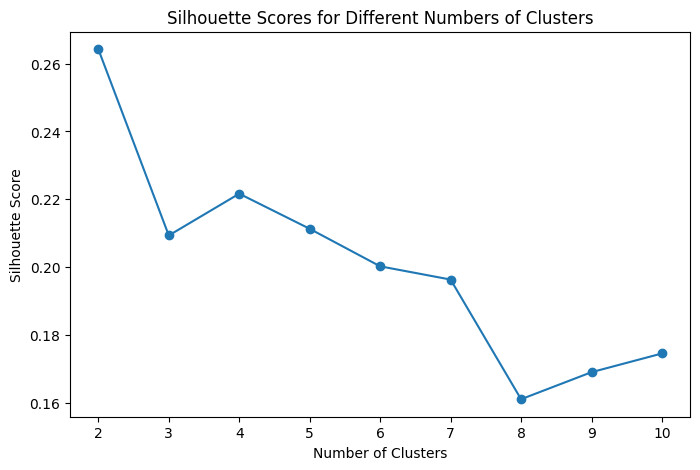

Optimal number of clusters: 2


In [169]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd

# Load your dataset (update 'file_path' with the correct dataset path)
file_path = 'spotify_cleaned_final.csv'
spotify_cleaned_final = pd.read_csv(file_path)

# Select the numerical columns for PCA
numeric_columns = ["danceability", "energy", "valence", "tempo", "loudness", "liveness"]
numeric_data = spotify_cleaned_final[numeric_columns]

# Standardize the features
scaler = StandardScaler()
data_standardized = scaler.fit_transform(numeric_data)

# Apply PCA
pca = PCA(n_components=None)  # Keep all components initially
data_pca = pca.fit_transform(data_standardized)

def optimize_clusters(data_pca, max_clusters=10):
    silhouette_scores = []
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(data_pca)
        score = silhouette_score(data_pca, labels)
        silhouette_scores.append(score)

    # Plot the Silhouette Scores
    plt.figure(figsize=(8, 5))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Different Numbers of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

    # Return the optimal number of clusters
    return silhouette_scores.index(max(silhouette_scores)) + 2

# Call the function
optimal_clusters = optimize_clusters(data_pca)
print(f"Optimal number of clusters: {optimal_clusters}")


In [130]:
import pandas as pd

# Load the cleaned dataset
file_path = 'spotify_cleaned_final.csv'
spotify_data = pd.read_csv(file_path)

In [43]:
!pip install langdetect

In [163]:
from langdetect import detect, DetectorFactory, LangDetectException
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from tabulate import tabulate

DetectorFactory.seed = 42  # Ensure consistent language detection results

def refined_recommendations_with_iterative_language_filtering(song_id, spotify_data, num_recommendations=10, n_components=3, n_clusters=5):
    """
    Refined recommendations with iterative language filtering.
    """
    if song_id not in spotify_data['track_id'].values:
        raise ValueError("Song ID not found in the dataset.")

    # Extract song details
    song = spotify_data.loc[spotify_data['track_id'] == song_id]
    song_title = song['track_name'].iloc[0]
    song_artist = song['artists'].iloc[0]
    song_genre = song['track_genre'].iloc[0]

    # Feature set for PCA
    feature_columns = ["danceability", "energy", "valence", "tempo", "loudness", "duration_ms", "liveness"]
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(spotify_data[feature_columns])

    # Apply PCA
    pca = PCA(n_components=n_components)
    pca_features = pca.fit_transform(scaled_features)
    spotify_data[[f'PC{i+1}' for i in range(n_components)]] = pca_features

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    spotify_data['cluster'] = kmeans.fit_predict(pca_features)

    # Filter by input song's cluster
    input_cluster = spotify_data.loc[spotify_data['track_id'] == song_id, 'cluster'].iloc[0]
    cluster_songs = spotify_data.loc[spotify_data['cluster'] == input_cluster].copy()

    # Further filter by genre
    cluster_songs = cluster_songs[
        (cluster_songs['track_genre'].str.contains(song_genre.split('-')[0], case=False))
    ]

    # Calculate distances in PCA space
    song_pca = spotify_data.loc[spotify_data['track_id'] == song_id, [f'PC{i+1}' for i in range(n_components)]].iloc[0]
    distances = euclidean_distances(cluster_songs[[f'PC{i+1}' for i in range(n_components)]], [song_pca])
    cluster_songs.loc[:, 'distance'] = distances.flatten()

    # Add weighted distance based on feature penalties
    cluster_songs.loc[:, 'weighted_distance'] = cluster_songs['distance'] + 0.7 * abs(cluster_songs['tempo'] - song['tempo'].iloc[0])

    # Sort recommendations
    recommendations = cluster_songs.loc[cluster_songs['track_id'] != song_id].sort_values(by="weighted_distance")

    # Detect language iteratively on top recommendations
    def detect_language_safe(text):
        try:
            return detect(text) if isinstance(text, str) and len(text.strip()) > 0 else 'unknown'
        except LangDetectException:
            return 'unknown'

    final_recommendations = []
    for _, row in recommendations.iterrows():
        if len(final_recommendations) >= num_recommendations:
            break
        if detect_language_safe(row['track_name']) == 'en':
            final_recommendations.append(row)

    # Convert back to DataFrame for output
    final_recommendations_df = pd.DataFrame(final_recommendations)

    return final_recommendations_df.head(num_recommendations), song_title, song_artist

# Example usage
filtered_song = spotify_data.loc[
    (spotify_data['track_name'].str.lower().str.contains('wait for u')) &
    (spotify_data['artists'].str.lower().str.contains('drake'))
]

if not filtered_song.empty:
    example_song_id = filtered_song['track_id'].iloc[0]
    recommendations, track_title, track_artist = refined_recommendations_with_iterative_language_filtering(example_song_id, spotify_data)
    print(f"Refined Recommendations for '{track_title}' by {track_artist}:")
    print(tabulate(recommendations[['track_name', 'artists', 'distance', 'weighted_distance']],
                   headers='keys', tablefmt='fancy_grid', showindex=False))
else:
    print("Song not found.")


Refined Recommendations for 'WAIT FOR U (feat. Drake & Tems)' by Future;Drake;Tems:
╒═══════════════════════════════════════════╤════════════════════════════════════════════╤════════════╤═════════════════════╕
│ track_name                                │ artists                                    │   distance │   weighted_distance │
╞═══════════════════════════════════════════╪════════════════════════════════════════════╪════════════╪═════════════════════╡
│ Oh Oh - The First Love of Tamizh          │ Anirudh Ravichander;Dhanush;Nikhita Gandhi │   0.636138 │             1.76524 │
├───────────────────────────────────────────┼────────────────────────────────────────────┼────────────┼─────────────────────┤
│ Ghost Unmasked - Background Score         │ Anirudh Ravichander                        │   0.730211 │             1.97411 │
├───────────────────────────────────────────┼────────────────────────────────────────────┼────────────┼─────────────────────┤
│ Thousand Miles                  

In [164]:
# Example usage
filtered_song = spotify_data.loc[
    (spotify_data['track_name'].str.lower().str.contains('fuck love')) &
    (spotify_data['artists'].str.lower().str.contains('xxxtentacion'))
]

if not filtered_song.empty:
    example_song_id = filtered_song['track_id'].iloc[0]
    recommendations, track_title, track_artist = refined_recommendations_with_iterative_language_filtering(example_song_id, spotify_data)
    print(f"Refined Recommendations for '{track_title}' by {track_artist}:")
    print(tabulate(recommendations[['track_name', 'artists', 'distance', 'weighted_distance']],
                   headers='keys', tablefmt='fancy_grid', showindex=False))
else:
    print("Song not found.")

Refined Recommendations for 'Fuck Love (feat. Trippie Redd)' by XXXTENTACION;Trippie Redd:
╒═══════════════════════════════╤════════════════════════╤════════════╤═════════════════════╕
│ track_name                    │ artists                │   distance │   weighted_distance │
╞═══════════════════════════════╪════════════════════════╪════════════╪═════════════════════╡
│ you're my everything          │ sadeyes                │   0.33304  │             0.86714 │
├───────────────────────────────┼────────────────────────┼────────────┼─────────────────────┤
│ Moving On                     │ Lil Peep               │   0.494315 │             1.14322 │
├───────────────────────────────┼────────────────────────┼────────────┼─────────────────────┤
│ all figured out               │ 44phantom              │   1.28319  │             2.89319 │
├───────────────────────────────┼────────────────────────┼────────────┼─────────────────────┤
│ Jocelyn Flores                │ XXXTENTACION           │   0.

In [165]:
# Example usage
filtered_song = spotify_data.loc[
    (spotify_data['track_name'].str.lower().str.contains('firework')) &
    (spotify_data['artists'].str.lower().str.contains('katy perry'))
]

if not filtered_song.empty:
    example_song_id = filtered_song['track_id'].iloc[0]
    recommendations, track_title, track_artist = refined_recommendations_with_iterative_language_filtering(example_song_id, spotify_data)
    print(f"Refined Recommendations for '{track_title}' by {track_artist}:")
    print(tabulate(recommendations[['track_name', 'artists', 'distance', 'weighted_distance']],
                   headers='keys', tablefmt='fancy_grid', showindex=False))
else:
    print("Song not found.")

Refined Recommendations for 'Firework' by Katy Perry:
╒═══════════════════════════════════╤════════════════════════════╤════════════╤═════════════════════╕
│ track_name                        │ artists                    │   distance │   weighted_distance │
╞═══════════════════════════════════╪════════════════════════════╪════════════╪═════════════════════╡
│ Birthday - Don Diablo Remix       │ Anne-Marie;Don Diablo      │   0.286772 │            0.361672 │
├───────────────────────────────────┼────────────────────────────┼────────────┼─────────────────────┤
│ This Is What You Came For         │ Calvin Harris;Rihanna      │   0.507686 │            0.582586 │
├───────────────────────────────────┼────────────────────────────┼────────────┼─────────────────────┤
│ Better Off Without You            │ Becky Hill;Shift K3Y       │   0.559192 │            0.603992 │
├───────────────────────────────────┼────────────────────────────┼────────────┼─────────────────────┤
│ 21 Reasons (feat. Ella Hen

In [166]:
# Example usage
filtered_song = spotify_data.loc[
    (spotify_data['track_name'].str.lower().str.contains('moonlight')) &
    (spotify_data['artists'].str.lower().str.contains('xxxtentacion'))
]

if not filtered_song.empty:
    example_song_id = filtered_song['track_id'].iloc[0]
    recommendations, track_title, track_artist = refined_recommendations_with_iterative_language_filtering(example_song_id, spotify_data)
    print(f"Refined Recommendations for '{track_title}' by {track_artist}:")
    print(tabulate(recommendations[['track_name', 'artists', 'distance', 'weighted_distance']],
                   headers='keys', tablefmt='fancy_grid', showindex=False))
else:
    print("Song not found.")

Refined Recommendations for 'Moonlight' by XXXTENTACION:
╒════════════════════════════════════╤════════════════════════════╤════════════╤═════════════════════╕
│ track_name                         │ artists                    │   distance │   weighted_distance │
╞════════════════════════════════════╪════════════════════════════╪════════════╪═════════════════════╡
│ Tell Me I'm A Wreck                │ Every Avenue               │   1.83754  │             1.91104 │
├────────────────────────────────────┼────────────────────────────┼────────────┼─────────────────────┤
│ Eat It Up                          │ XXXTENTACION               │   0.543203 │             1.9376  │
├────────────────────────────────────┼────────────────────────────┼────────────┼─────────────────────┤
│ Everybody Dies In Their Nightmares │ XXXTENTACION               │   0.76863  │             2.12943 │
├────────────────────────────────────┼────────────────────────────┼────────────┼─────────────────────┤
│ Chain         

In [167]:
# Example usage
filtered_song = spotify_data.loc[
    (spotify_data['track_name'].str.lower().str.contains('one dance')) &
    (spotify_data['artists'].str.lower().str.contains('drake'))
]

if not filtered_song.empty:
    example_song_id = filtered_song['track_id'].iloc[0]
    recommendations, track_title, track_artist = refined_recommendations_with_iterative_language_filtering(example_song_id, spotify_data)
    print(f"Refined Recommendations for '{track_title}' by {track_artist}:")
    print(tabulate(recommendations[['track_name', 'artists', 'distance', 'weighted_distance']],
                   headers='keys', tablefmt='fancy_grid', showindex=False))
else:
    print("Song not found.")

Refined Recommendations for 'One Dance' by Drake;Wizkid;Kyla:
╒════════════════════════════════════════════╤═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤════════════╤═════════════════════╕
│ track_name                                 │ artists                                                                                                                                                                                                                                                             │   distance │   weighted_distance │
╞════════════════════════════════════════════╪════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════

In [168]:
# Example usage
filtered_song = spotify_data.loc[
    (spotify_data['track_name'].str.lower().str.contains('rio')) &
    (spotify_data['artists'].str.lower().str.contains('duran duran'))
]

if not filtered_song.empty:
    example_song_id = filtered_song['track_id'].iloc[0]
    recommendations, track_title, track_artist = refined_recommendations_with_iterative_language_filtering(example_song_id, spotify_data)
    print(f"Refined Recommendations for '{track_title}' by {track_artist}:")
    print(tabulate(recommendations[['track_name', 'artists', 'distance', 'weighted_distance']],
                   headers='keys', tablefmt='fancy_grid', showindex=False))
else:
    print("Song not found.")

Refined Recommendations for 'Rio - 2009 Remaster' by Duran Duran:
╒═════════════════════════════════════════════════════════════════════════════════╤════════════════╤════════════╤═════════════════════╕
│ track_name                                                                      │ artists        │   distance │   weighted_distance │
╞═════════════════════════════════════════════════════════════════════════════════╪════════════════╪════════════╪═════════════════════╡
│ A Friend I Call Desire - 2009 Remaster                                          │ Ultravox       │   0.455376 │             1.01958 │
├─────────────────────────────────────────────────────────────────────────────────┼────────────────┼────────────┼─────────────────────┤
│ Mine for Life - 2009 Remaster                                                   │ Ultravox       │   0.333815 │             1.69182 │
├─────────────────────────────────────────────────────────────────────────────────┼────────────────┼────────────┼─────